# Retrieving observation data from the Minor Planet Centre
Copyright (c) 2010-2023, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
The [Minor Planet Centre](https://www.minorplanetcenter.net/) (MPC) provides positional elements and observation data for minor planets, comets and outer irregular natural satellites of the major planets. Tudat's BatchMPC class allows for the retrieval and processing of observational data for these objects. This example highlights the complete functionality of the BatchMPC class itself. The [Estimation with MPC](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html) example showcases estimation with MPC observations, but we recommend going through this example first.

MPC receives and stores observations from observatories across the world. These are optical observations in a Right Ascension (RA) and Declination (DEC) format which are processed into an Earth-inertial J2000 format. Objects are all assigned a unique minor-planet designation number (see examples below), comets use a distinct designation. Larger objects are often also given a name (only about 4% have been given a name currently). Similarly, observatories are also assigned a unique 3 symbol code.

The following objects will be used in the example:

- [1 Ceres](https://en.wikipedia.org/wiki/Ceres_(dwarf_planet))
- [4 Vesta](https://en.wikipedia.org/wiki/4_Vesta)
- [433 Eros](https://en.wikipedia.org/wiki/433_Eros)

## Basic Usage

### Import statements
In this example we do not perform an estimation, as such we only need the batchMPC class from data, environment_setup and observation to convert our observations to Tudat and optionally datetime to filter our batch. We also load the standard SPICE kernels.

In [1]:
from tudatpy.data.mpc import BatchMPC
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from tudatpy.kernel.interface import spice

from datetime import datetime

# Load spice kernels
spice.load_standard_kernels()


### Retrieval

We initialise a `BatchMPC` object, create a list with the objects we want and use `.get_observations()` to retrieve the observations. `.get_observations()` uses [astroquery](https://astroquery.readthedocs.io/en/latest/mpc/mpc.html) to retrieve data from MPC and requires an internet connection. The observations are cached for faster retrieval in subsequent runs. The `BatchMPC` object removes duplicates if `.get_observations()` is ran twice.

Tudat's estimation tools allow for multiple Objects to be analysed at the same time. BatchMPC can process multiple objects into a single observation collection automatically. For now lets retrieve the observations for Ceres and Eros. BatchMPC uses MPC codes for objects and observatories. To get an overview of the batch we can use the `summary()` method. Let's also get some details on some of the observatories that retrieved the data using the `observatories_table()` method.

In [2]:
asteroid_MPC_codes = [1, 433]

batch1 = BatchMPC()

batch1.get_observations(asteroid_MPC_codes)

batch1.summary()
print(batch1.observatories_table(only_in_batch=True, only_space_telescopes=False, include_positions=False))
print("Space Telescopes:")
print(batch1.observatories_table(only_in_batch=True, only_space_telescopes=True, include_positions=False))


   Batch Summary:
1. Batch includes 2 minor planets:
   ['1', '433']
2. Batch includes 20428 observations, including 1980 observations from space telescopes
3. The observations range from 1801-01-01 19:49:52.319986 to 2023-08-22 22:03:05.184015
   In seconds TDB since J2000: -6279782975.49596 to 746013854.3668225
   In Julian Days: 2378862.3263 to 2460179.41881
4. The batch contains observations from 393 observatories, including 3 space telescopes

     Code                                   Name  count
0     000                              Greenwich  230.0
6     006           Fabra Observatory, Barcelona  250.0
7     007                                  Paris    7.0
8     008                      Algiers-Bouzareah  559.0
12    012                                  Uccle  155.0
...   ...                                    ...    ...
2335  Y16            ROCG, Campos dos Goytacazes    3.0
2369  Z22       MASTER-IAC Observatory, Tenerife   88.0
2399  Z52      The Studios Observatory, Gr

We can also directly have a look at the the observations themselves, for example, lets take a look at the first and final observations from TESS and WISE. The table property allows for read only access to the observations in pandas dataframe format. 

In [3]:
obs_by_TESS = batch1.table.query("observatory == 'C57'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]
obs_by_WISE = batch1.table.query("observatory == 'C51'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]

print("Initial and Final Observations by TESS")
print(obs_by_TESS)
print("Initial and Final Observations by WISE")
print(obs_by_WISE)

Initial and Final Observations by TESS
      number                   epochUTC        RA       DEC
11601    433 2021-06-06 21:34:01.804817  4.753241 -0.722587
13220    433 2021-06-24 04:44:01.103987  4.588734 -0.674985
Initial and Final Observations by WISE
      number                   epochUTC        RA       DEC
6124       1 2010-03-20 16:07:19.718382  4.714012 -0.369629
13536    433 2023-05-15 12:31:37.344004  5.690128 -0.311711


### Filtering

From the summary we can see that even Piazzi's first observations of Ceres are included. This is not ideal. We might also want to exclude some observatories. To fix this we use the `.filter()` method. Dates can be filtered using the standard seconds since J2000 TDB format or through python's datetime standard library in UTC for simplicity. Additionally, specific bands can be selected and observatories can explicitly be included or excluded. The `.filter()` method alters the original batch in place.

In [4]:
observatories_to_exlude = ["000", "C59"]

print(f"Size before filter: {batch1.size}")
batch1.filter(observatories_exclude=observatories_to_exlude, epoch_start=datetime(2018, 1, 1), epoch_end=746013855.0)
print(f"Size after filter: {batch1.size}")

batch1.summary()

Size before filter: 20428
Size after filter: 3471

   Batch Summary:
1. Batch includes 2 minor planets:
   ['1', '433']
2. Batch includes 3471 observations, including 1848 observations from space telescopes
3. The observations range from 2018-01-20 10:01:17.183998 to 2023-08-22 22:03:05.184015
   In seconds TDB since J2000: 569714546.3684946 to 746013854.3668225
   In Julian Days: 2458138.91756 to 2460179.41881
4. The batch contains observations from 77 observatories, including 2 space telescopes



### Set up the system of bodies
Transforming the observations to a tudat compatible format requires setting up an environment. For the purposes of this example, we keep it as simple as possible. See the [Estimation with MPC](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html) for a more complete setup and explanation appropriate for estimation. For our bodies, we only use Earth (required to host our terrestrial observatories) and the Sun. We set our origin to `"SSB"`, the solar system barycenter. We use the default body settings from the `SPICE` kernel to initialise the planet and use it to create a system of bodies. This system of bodies is used in the `to_tudat()` method.

In [5]:
bodies_to_create = ["Sun", "Earth"]

# Create default body settings
global_frame_origin = "SSB"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Retrieve Observation Collection


Now that our batch is ready, we can transform it to a Tudat `ObservationCollection` object using the `to_tudat()` method.

The `.to_tudat()` does the following for us:

1. Creates an empty body for each minor planet with their MPC code as a name.
2. Adds this body to the system of bodies inputted to the method.
3. Retrieves the global position of the terrestrial observatories in the batch and adds these stations to the Tudat environment.
4. Creates link definitions between each unique terrestrial observatory/ minor planet combination in the batch.
5. (Optionally) creates a link definition between each space telescope / minor planet combination in the batch. This requires an addional input.
6. Creates a `SingleObservationSet` object for each unique link that includes all observations for that link.
7. Returns an `ObservationCollection` object and a dictionary with the unique link definitions in a dictionary with key strings "MPCPlanet_MPCobservatory". For example: the key for the link Ceres-> Fabra Observatory would be "1_006".

By default, space telescopes like WISE and TESS are excluded from the `ObservationCollection`. To utilise their observations, dynamics of the satellites are required. The "Additional Features" section of this example shows a rudimental version of how this can be done. The '.to_tudat()' method does not alter the batch object itself.

In [6]:
observation_collection, links_dict = batch1.to_tudat(bodies)

The names of the bodies added to the system of bodies object as well as the dates of the oldest and latest observations can be retrieved from the batch:

In [7]:
epoch_start = batch1.epoch_start
epoch_end = batch1.epoch_end
object_names = batch1.MPC_objects

The `to_tudat()` method returns the links themselves, this is done to enable straightforward addition biases and corrections if necessary. For now we just keep the settings default.

In [8]:
# Manual method:
observation_settings_list = list()
for link in list(links_dict.values()):
    # add optional bias settings
    observation_settings_list.append(observation.angular_position(link, bias_settings = None))


With the `observation_collection` and `observation_settings_list` ready, we have all the observation inputs we need to perform an estimation. Next, lets verify the observations. Next, check out the [Estimation with MPC](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html) example to try estimation with the observations we have retrieved here. The remainder of the example discusses additional features.

## Additional Features

### Using satellite observations.
Space Telescopes in Tudat are treated as bodies instead of stations. To use their observations, their motion should be known to Tudat. A user may for example retrieve their ephemirides from a SPICE kernel or propagate the satellite. This body must then be linked to the MPC code for that space telescope when calling the `to_tudat()` method. The MPC code for TESS can be obtained using the `observatories_table()` method as used previously. Bellow is an example using a spice kernel.

In [9]:
# Note that we are using the add_empty_settings() method instead of add_empty_body().
# This allows us to add ephemeris settings, 
# which tudat uses to create an ephemeris which is consistent with the rest of the environment.
TESS_code = "-95"
body_settings.add_empty_settings("TESS")

# Set up the space telescope's dynamics
# the spice kernel can be retrieved from: https://archive.stsci.edu/missions/tess/models/
spice.load_kernel(r"tess_20_year_long_predictive.bsp")
body_settings.get("TESS").ephemeris_settings =  environment_setup.ephemeris.direct_spice(
     global_frame_origin, global_frame_orientation, TESS_code)

# NOTE this is incorrect, we are trying to set the ephemeris directly:
# bodies.create_empty_body("TESS")
# bodies.get("TESS").ephemeris = environment_setup.ephemeris.direct_spice(
#      global_frame_origin, global_frame_orientation, TESS_code)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)
# create dictionary to link names. MPCcode:NameInTudat
sats_dict = {"C57":"TESS"}

observation_collection, links_dict = batch1.to_tudat(bodies, included_satellites=sats_dict)

### Manual retrieval from astroquery
Those familiar with astroquery (or those who have existing filitering/ retrieval processes) may use the `from_astropy()` and `from_pandas()` methods to still use `to_tudat()` functionality. The input must meet some requirements which can be found in the API documentation, the default format from astroquery fits these requirements.

In [10]:
from astroquery.mpc import MPC

mpc_code_vesta = 4
data = MPC.get_observations(mpc_code_vesta)

# ...
# Any additional filtering steps
# ...

batch2 = BatchMPC()
batch2.from_astropy(data)

# alternative if pandas is preffered:
# data_pandas = data.to_pandas()
# batch2.from_astropy(data_pandas)

batch2.summary()


   Batch Summary:
1. Batch includes 1 minor planets:
   ['4']
2. Batch includes 8236 observations, including 182 observations from space telescopes
3. The observations range from 1821-01-29 21:28:28.992018 to 2023-08-14 11:36:52.416016
   In seconds TDB since J2000: -5646205858.823204 to 745285081.5989838
   In Julian Days: 2386195.39478 to 2460170.98394
4. The batch contains observations from 174 observatories, including 1 space telescopes



### Combining batches

Batches can be combined using the `+` operator, duplicates are removed.

In [11]:
batch3 = batch2 + batch1
batch3.summary()


   Batch Summary:
1. Batch includes 3 minor planets:
   ['4', '1', '433']
2. Batch includes 11707 observations, including 2030 observations from space telescopes
3. The observations range from 1821-01-29 21:28:28.992018 to 2023-08-22 22:03:05.184015
   In seconds TDB since J2000: -5646205858.823204 to 746013854.3668225
   In Julian Days: 2386195.39478 to 2460179.41881
4. The batch contains observations from 225 observatories, including 2 space telescopes



### Copying and non in-place filtering
We may want to compare results between batches. In that case it is usefull to copy a batch or perform non-destructive filtering:

In [12]:
# Copying existing batches:
import copy
batch1_copy = copy.copy(batch1)
# simpler equivalent:
batch1_copy = batch1.copy()

# normal in-place/destructive filter
batch1_copy.filter(epoch_start=datetime(2023, 1, 1)) # returns None
# non-destructive filter:
batch1_copy2 = batch1.filter(epoch_start=datetime(2023, 1, 1), in_place=False) # returns filtered copy

batch1_copy.summary()
batch1_copy2.summary()


   Batch Summary:
1. Batch includes 2 minor planets:
   ['1', '433']
2. Batch includes 310 observations, including 42 observations from space telescopes
3. The observations range from 2023-02-15 16:51:29.952005 to 2023-08-22 22:03:05.184015
   In seconds TDB since J2000: 729751959.137106 to 746013854.3668225
   In Julian Days: 2459991.20243 to 2460179.41881
4. The batch contains observations from 22 observatories, including 1 space telescopes


   Batch Summary:
1. Batch includes 2 minor planets:
   ['1', '433']
2. Batch includes 310 observations, including 42 observations from space telescopes
3. The observations range from 2023-02-15 16:51:29.952005 to 2023-08-22 22:03:05.184015
   In seconds TDB since J2000: 729751959.137106 to 746013854.3668225
   In Julian Days: 2459991.20243 to 2460179.41881
4. The batch contains observations from 22 observatories, including 1 space telescopes



### Plotting observations
The `.plot_observations()` method can be used to make a quick plot of the observations

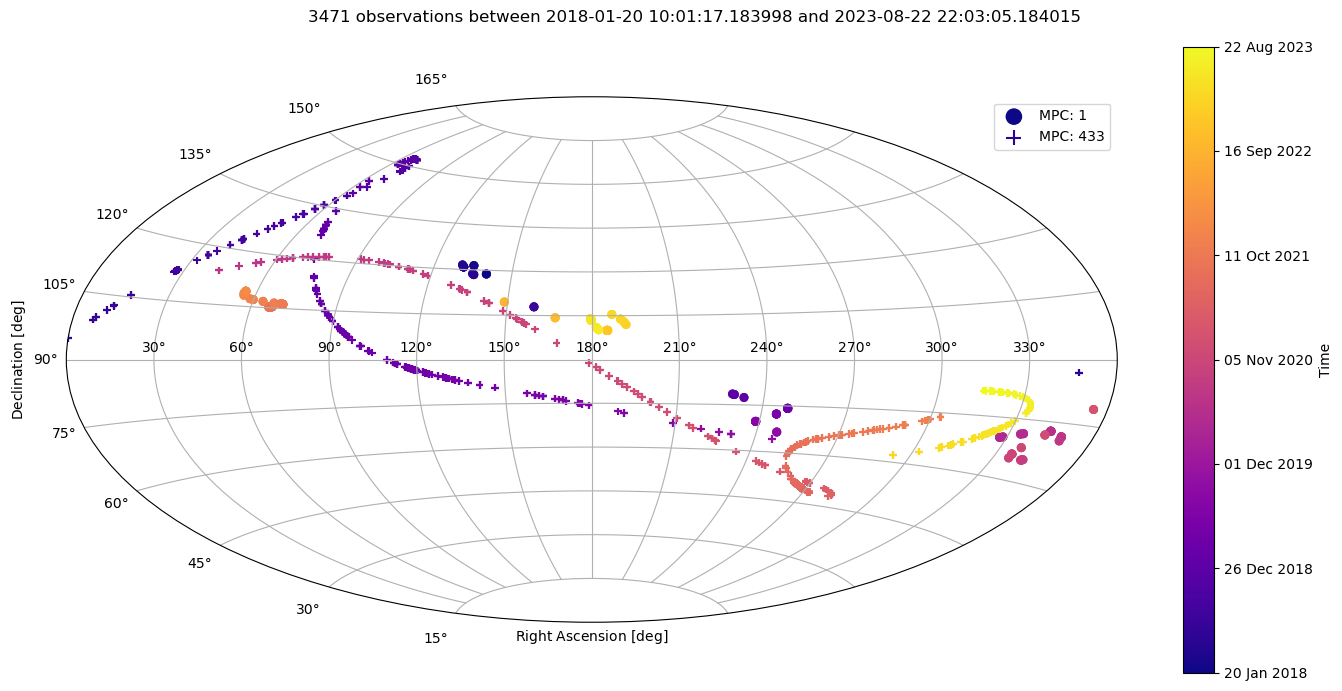

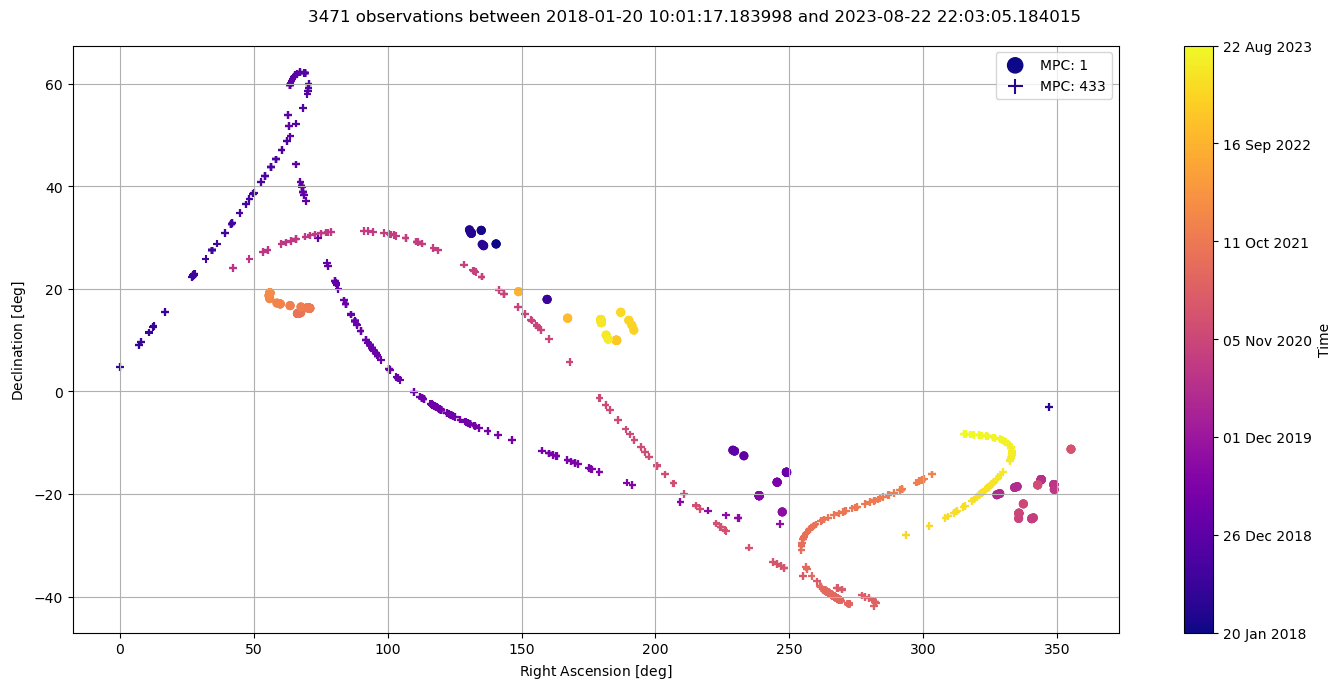

In [14]:
import matplotlib.pyplot as plt

# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
fig = batch1.plot_observations(projection="aitoff")
fig = batch1.plot_observations(projection=None)

plt.show()